## Prerequisites
To run the code in this article, you will need the following libraries:

1. GridDB C Client
2. GridDB Python client

Follow the instructions on the [GridDB Python Package Index (Pypi)](https://pypi.org/project/griddb-python/) page to install these clients.
You will also need to install TensorFlow, yfinance, Numpy, Pandas, and Matplotlib libraries.

The scripts below will help you install and import the necessary libraries for running the code in this article.

In [ ]:
import os
import absl.logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import yfinance as yf
import pandas as pd
import griddb_python as griddb
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import disable_interactive_logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



## Inserting Stock Market Data into GridDB

### Fetch data from Yahoo Finance

In [ ]:
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2023-12-31"
data = yf.download(ticker, start=start_date, end=end_date)
print(f"Fetched {len(data)} rows of data for {ticker}")
data.head()

[*********************100%***********************]  1 of 1 completed

Fetched 250 rows of data for AAPL


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,123.904625,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.182610,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,123.855103,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.412231,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,128.937286,70790800


### Connect to GridDB

In [ ]:

# GridDB connection details
DB_HOST = "127.0.0.1:10001"
DB_CLUSTER = "myCluster"
DB_USER = "admin"
DB_PASS = "admin"

# creating a connection

factory = griddb.StoreFactory.get_instance()

try:
    gridstore = factory.get_store(
        notification_member = DB_HOST,
        cluster_name = DB_CLUSTER,
        username = DB_USER,
        password = DB_PASS
    )

    container1 = gridstore.get_container("container1")
    if container1 == None:
        print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))

Container does not exist
Successfully connected to GridDB


### Create Container for Stock Data in GridDB

In [ ]:
container_name = f"{ticker}_stock_data"
column_info = [
    ["Timestamp", griddb.Type.TIMESTAMP],
    ["Open", griddb.Type.DOUBLE],
    ["High", griddb.Type.DOUBLE],
    ["Low", griddb.Type.DOUBLE],
    ["Close", griddb.Type.DOUBLE],
    ["Volume", griddb.Type.LONG]
]
container_info = griddb.ContainerInfo(container_name, column_info, griddb.ContainerType.TIME_SERIES)

try:
    gridstore.put_container(container_info)
    container = gridstore.get_container(container_name)
    if container is None:
        print(f"Failed to create or retrieve container: {container_name}")
    else:
        print(f"Successfully created and retrieved container: {container_name}")
except griddb.GSException as e:
    print(f"Error creating or retrieving container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}]")
        print(f"Error code: {e.get_error_code(i)}")
        print(f"Location: {e.get_location(i)}")
        print(f"Message: {e.get_message(i)}")

Successfully created and retrieved container: AAPL_stock_data


### Insert Data into GridDB Container

In [ ]:
try:
    for index, row in data.iterrows():
        container.put([index.to_pydatetime(), row['Open'], row['High'], row['Low'], row['Close'], int(row['Volume'])])
    print(f"Successfully inserted {len(data)} rows of data into {container_name}")
except griddb.GSException as e:
    print(f"Error inserting data into container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}]")
        print(f"Error code: {e.get_error_code(i)}")
        print(f"Location: {e.get_location(i)}")
        print(f"Message: {e.get_message(i)}")

Successfully inserted 250 rows of data into AAPL_stock_data


## Creating a Stock Market Forecasting Model Using TensorFlow Keras

### Retrieving Data from GridDB

In [ ]:
def retrieve_data_from_griddb(container_name):

    try:
        stock_data_container = gridstore.get_container(container_name)

        # Query all data from the container
        query = stock_data_container.query("select *")
        rs = query.fetch()  # Adjust the number based on your data size

        data = rs.fetch_rows()
        data .set_index("Timestamp", inplace=True)
        return data

    except griddb.GSException as e:
        print(f"Error retrieving data from GridDB: {e.get_message()}")
        return none


stock_data = retrieve_data_from_griddb("AAPL_stock_data")
stock_data.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,70790800


### Data Preprocessing for Keras Transformer Model

In [ ]:
features = ['Open', 'Volume']
data = stock_data[features].values

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform
data_normalized = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  # Predicting next day's Open price
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(data_normalized, seq_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



### Creating a TensorFlow Keras Transformer Model

In [ ]:
# Define the Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
# Build the model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
# Create the model
input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",
    metrics=["mae"]
)

In [ ]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6),
]

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.7085 - mae: 0.7833 - val_loss: 0.8154 - val_mae: 0.8997 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6146 - mae: 0.7292 - val_loss: 0.7748 - val_mae: 0.8768 - learning_rate: 1.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6002 - mae: 0.7228 - val_loss: 0.7361 - val_mae: 0.8545 - learning_rate: 1.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6090 - mae: 0.7252 - val_loss: 0.6996 - val_mae: 0.8330 - learning_rate: 1.0000e-04
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5136 - mae: 0.6644 - val_loss: 0.6657 - val_mae: 0.8124 - learning_rate: 1.0000e-04
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5480 - mae: 0.6869 - val_loss: 0.6334 - val_mae: 0.7924 - learning_rate: 1.0000e-04
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5048 - mae: 0.6591 - val_loss: 0.6038 - val_mae: 0.7735 - learning_rate: 1.0

### Evaluating the Model Performance

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

# When making predictions and inverse transforming:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions (for Open price only)
train_predictions = scaler.inverse_transform(np.column_stack((train_predictions, np.zeros_like(train_predictions))))[:, 0]
test_predictions = scaler.inverse_transform(np.column_stack((test_predictions, np.zeros_like(test_predictions))))[:, 0]

# Inverse transform actual values
y_train_actual = scaler.inverse_transform(np.column_stack((y_train.reshape(-1, 1), np.zeros_like(y_train.reshape(-1, 1)))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1)))))[:, 0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0288 - mae: 0.1510 
Test MAE: 0.1596
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


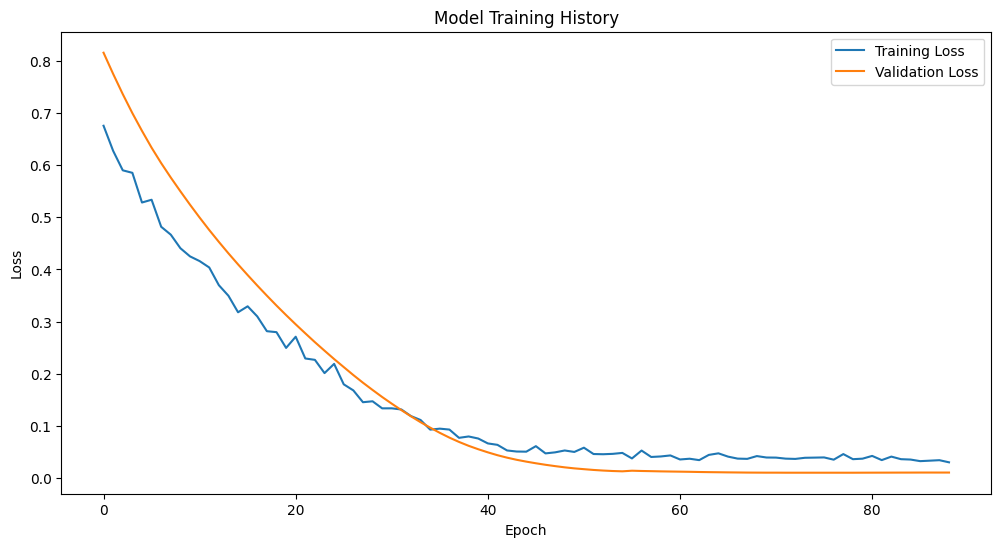

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

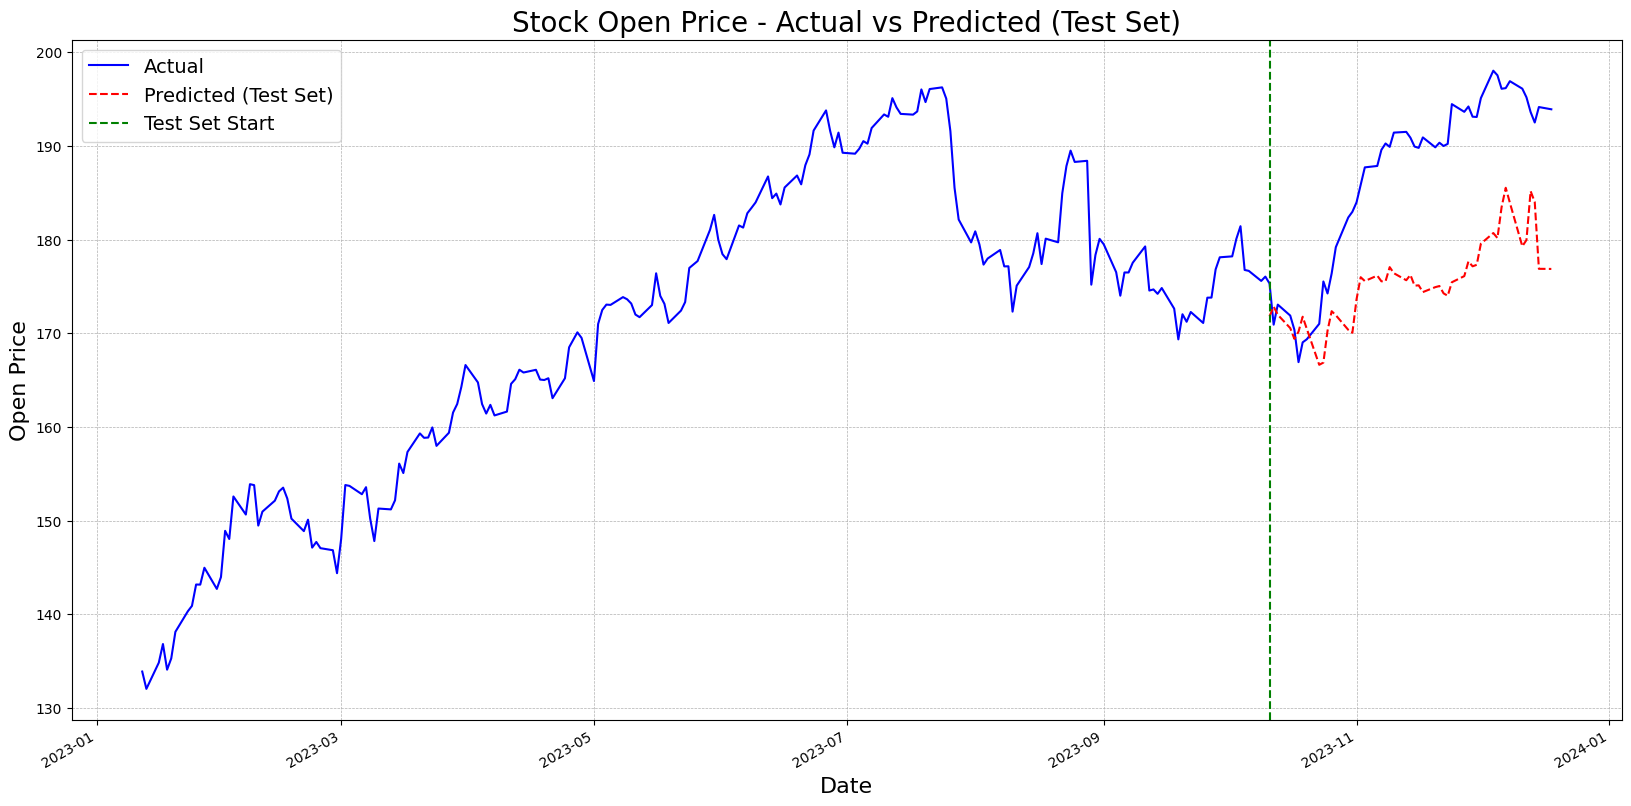

In [ ]:
# Get the actual prices for the entire dataset
y_actual = np.concatenate([y_train_actual, y_test_actual])

# Create a date range for the entire dataset
full_date_range = pd.date_range(start=stock_data.index[seq_length], periods=len(y_actual), freq='B')

# Get the date range for the test set
test_date_range = full_date_range[-len(y_test_actual):]

# Plot results
plt.figure(figsize=(20, 10))

# Plot the entire actual price series
plt.plot(full_date_range, y_actual, label='Actual', color='blue')

# Plot only the test predictions
plt.plot(test_date_range, test_predictions, label='Predicted (Test Set)', color='red', linestyle='--')

# Add a vertical line to indicate the start of the test set
split_date = full_date_range[-len(y_test_actual)]
plt.axvline(x=split_date, color='green', linestyle='--', label='Test Set Start')

plt.title('Stock Open Price - Actual vs Predicted (Test Set)', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()


# Show the plot
plt.show()
